In [4]:
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [2]:
df2 = pd.read_csv("/Users/user/PycharmProjects/Drug Design FInal/FINAL_GIT/Raw Files/merged_features_IC50_g12c.csv")
df2

In [5]:
import numpy as np
import pandas as pd
def pIC50(input):
    pIC50 = []

    input["IC50 (nM)"] = pd.to_numeric(input["IC50 (nM)"],errors='coerce')

    for i in input["IC50 (nM)"]:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input["pIC50"]

    return x

In [6]:
filename = "/Users/user/PycharmProjects/Drug Design FInal/FINAL_GIT/Raw Files/merged_features_IC50_g12c.csv"
#df = pd.read_csv("fda_original.csv",sep=";")
df2 = pd.read_csv(filename)
df2.dropna(subset=['IC50 (nM)'], inplace=True)
df2['IC50 (nM)'] = pIC50(df2)
df2['IC50 (nM)'] = df2['pIC50']  # Replace 'SV' column with pIC50 values

# Drop 'pIC50' column (optional) as it's now redundant
df2.drop(columns=['pIC50'], inplace=True)

df2

,ChEMBL ID,Smiles,FC,N,H,Cl,Br,I,P,F,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,IC50 (nM)
0,1396159,CN1CCC[C@H]1COc1nc(N2CCN([C@@H](CC#N)C2)C(=O)C...,0,308,34,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,9.309804
1,1396154,Fc1c(ncc2c(nc(OCC3(CN4CCCC4)CC3)nc12)N1CCN([C@...,0,336,35,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,9.229148
2,1396157,F[C@H]1CN2CCC[C@@]2(COc2nc(N3CCN([C@@H](CC#N)C...,0,330,34,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,9.229148
3,1396156,F[C@H]1CN2CCC[C@@]2(COc2nc(N3CCN([C@@H](CC#N)C...,0,322,35,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,9.148742
4,1396158,CN1CCC[C@H]1COc1nc(N2CCN([C@@H](CC#N)C2)C(=O)C...,0,300,35,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,9.148742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,1252347,CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...,0,530,72,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.259637
1166,1252348,CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...,0,498,65,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.259637
1167,1252349,CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...,0,498,65,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.259637
1168,1252352,CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...,0,498,68,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.259637


In [9]:
import numpy as np
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

# --- Load Data ---
df2.dropna(subset=['IC50 (nM)'], inplace=True)
X = df2.drop(columns=['IC50 (nM)', 'Smiles', 'ChEMBL ID'])
y = df2['IC50 (nM)']

# --- Initialize Pipeline ---
pipe = Pipeline([
    ('variance_threshold', VarianceThreshold(threshold=0.8*(1-0.8))),
    ('univariate_select', SelectKBest(score_func=f_regression, k=50)),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(max_depth=20, min_samples_leaf=10, random_state=42))
])

# --- Load New Data ---
new_descriptors = pd.read_csv('/Users/user/PycharmProjects/Drug Design FInal/FINAL_GIT/Raw Files/FDA_Hyb_Features.csv')
new_descriptors.dropna(inplace=True)
chembl_id_column = new_descriptors['ChEMBL ID']
smiles_column = new_descriptors['Smiles']
X_new = new_descriptors.drop(columns=['ChEMBL ID', 'Smiles'])

# --- Align New Data with Training Features ---
missing_cols = set(X.columns) - set(X_new.columns)
for col in missing_cols:
    X_new[col] = 0  # Add missing columns with 0
X_new = X_new[X.columns]  # Ensure column order matches

# --- Track Results ---
loop_results_df = pd.DataFrame(columns=['ChEMBL ID', 'Smiles', 'Predicted Value'])
predicted_values = {chembl_id: [] for chembl_id in chembl_id_column.unique()}
feature_importances = []
perm_importances = []
all_selected_features = []

# --- Main Loop ---
for i in range(50):  # 50 iterations
    pipe.fit(X, y)
    
    # Get selected features for this iteration
    vt_mask = pipe.named_steps['variance_threshold'].get_support()
    remaining_features = X.columns[vt_mask].tolist()
    skb_mask = pipe.named_steps['univariate_select'].get_support()
    selected_features = [remaining_features[i] for i in range(len(remaining_features)) if skb_mask[i]]
    all_selected_features.append(selected_features)
    
    # Predict
    loop_predicted_values = pipe.predict(X_new)
    
    # Store predictions
    loop_df = pd.DataFrame({
        'ChEMBL ID': chembl_id_column,
        'Smiles': smiles_column,
        'Predicted Value': loop_predicted_values
    }).sort_values('Predicted Value', ascending=False)
    
    loop_results_df = pd.concat([loop_results_df, loop_df.head(10)])
    
    # Store predicted values per ChEMBL ID
    for chembl_id, pred in zip(chembl_id_column, loop_predicted_values):
        predicted_values[chembl_id].append(pred)
    
    # Get feature importances (only for selected features)
    rf_model = pipe.named_steps['model']
    feature_importances.append(rf_model.feature_importances_)
    
    # Get permutation importance (on selected features)
    X_transformed = pipe[:-1].transform(X)  # Apply all steps except model
    result = permutation_importance(
        pipe.named_steps['model'], 
        X_transformed, 
        y, 
        n_repeats=10, 
        random_state=42
    )
    perm_importances.append(result.importances_mean)

# --- Post-Processing ---
# Average importances (only for selected features)
avg_feature_importance = np.mean(feature_importances, axis=0)
avg_perm_importance = np.mean(perm_importances, axis=0)

# Create importance DataFrames
feature_df = pd.DataFrame({
    'Feature': selected_features,  # Use the last iteration's selected features
    'Importance': avg_feature_importance
}).sort_values('Importance', ascending=False)

perm_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': avg_perm_importance
}).sort_values('Importance', ascending=False)

# --- Analyze Top Predictions ---
value_counts = loop_results_df['ChEMBL ID'].value_counts(normalize=True) * 10
top_10_chembl_ids = value_counts.head(10).index

/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_5182/588334143.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  loop_results_df = pd.concat([loop_results_df, loop_df.head(10)])


In [14]:
#code without feature selection
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

# Load training descriptors data
#df1 = df1.loc[:, ~df1.columns.str.contains('Unnamed')]
df2.dropna(subset=['IC50 (nM)'], inplace=True)
X = df2.drop(columns=['IC50 (nM)','Smiles', 'ChEMBL ID'])
y = df2['IC50 (nM)']

# Initialize model and pipeline
model = RandomForestRegressor(max_depth=20, min_samples_leaf=10)
pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])

# Load new descriptors data
new_descriptors = pd.read_csv('/Users/user/PycharmProjects/Drug Design FInal/FINAL_GIT/Raw Files/FDA_Hyb_Features.csv')
new_descriptors.dropna(inplace=True)

# Extract ChEMBL IDs and SMILES
chembl_id_column = new_descriptors['ChEMBL ID']
smiles_column = new_descriptors['Smiles']
new_descriptors.drop(columns=['ChEMBL ID', 'Smiles'], inplace=True)

# Ensure new_descriptors has the same columns as X
missing_cols = set(X.columns) - set(new_descriptors.columns)  # Columns missing in new data
extra_cols = set(new_descriptors.columns) - set(X.columns)  # Extra columns in new data

# Add missing columns with zero values
for col in missing_cols:
    new_descriptors[col] = 0

# Drop extra columns
new_descriptors = new_descriptors[X.columns]  # Reorder and drop extras

# Now X and new_descriptors have identical columns

# Initialize a DataFrame to store results
loop_results_df = pd.DataFrame(columns=['ChEMBL ID', 'Smiles', 'Predicted Value'])

# Number of iterations
loop_n = 50

# Dictionary to store predicted values for each ChEMBL ID
predicted_values = {chembl_id: [] for chembl_id in chembl_id_column.unique()}
feature_importances = []
perm_importances = []
# Run the loop to fit the model and predict the values
for i in range(loop_n):
    pipe.fit(X, y)

    # Get regular feature importance
    rf_model = pipe.named_steps['model']
    feature_importances.append(rf_model.feature_importances_)

    # Get permutation importance
    result = permutation_importance(pipe, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    perm_importances.append(result.importances_mean)

    loop_predicted_values = pipe.predict(new_descriptors)

    loop_df = pd.DataFrame({
        'ChEMBL ID': chembl_id_column,
        'Smiles': smiles_column,
        'Predicted Value': loop_predicted_values
    })
    loop_df.sort_values(by='Predicted Value', ascending=False, inplace=True)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        loop_results_df = pd.concat([loop_results_df, loop_df.head(10)])

    # Store the predicted values for each ChEMBL ID
    for chembl_id, predicted_value in zip(chembl_id_column, loop_predicted_values):
        if chembl_id in predicted_values:
            predicted_values[chembl_id].append(predicted_value)

# Average the importances across all iterations
avg_feature_importance = np.mean(feature_importances, axis=0)
avg_perm_importance = np.mean(perm_importances, axis=0)

# Create DataFrames for visualization
feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': avg_feature_importance
}).sort_values('Importance', ascending=False)

perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': avg_perm_importance
}).sort_values('Importance', ascending=False)



# Calculate frequency of each ChEMBL ID in the top 10
value_counts = loop_results_df['ChEMBL ID'].value_counts(normalize=True) * 10
#print(value_counts)

# Get the top 13 ChEMBL IDs
top_10_chembl_ids = value_counts.head(10).index

<Figure size 1200x800 with 0 Axes>

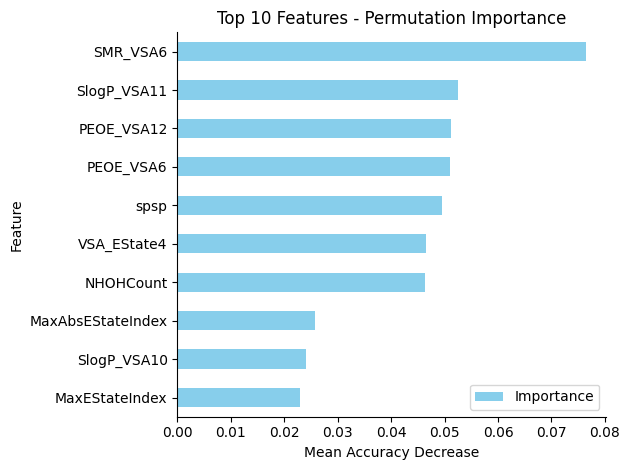

In [10]:
# Plot Permutation Importance
plt.figure(figsize=(12, 8))
perm_df.head(10).sort_values('Importance', ascending=True).plot.barh(
    x='Feature', y='Importance', color='skyblue'
)
plt.title('Top 10 Features - Permutation Importance')
plt.xlabel('Mean Accuracy Decrease')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('permutation_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
mean_values = {chembl_id: np.mean(predicted_values[chembl_id]) for chembl_id in top_10_chembl_ids}
std_dev_values = {chembl_id: np.std(predicted_values[chembl_id]) for chembl_id in top_10_chembl_ids}

summary_df = pd.DataFrame({
    'ChEMBL ID': top_10_chembl_ids,
    'Frequency': [value_counts[chembl_id] for chembl_id in top_10_chembl_ids],
    'Avg Predicted Value': [mean_values[chembl_id] for chembl_id in top_10_chembl_ids]
})

summary_df.head(10)
summary_df.to_csv("RF_molecules_Newfeatures_G12C.csv", index=False)